## implement NSGA-II pythonで

In [1]:
import numpy as np
import random


step1: 初期集団の生成

In [2]:
def initialize_population(pop_size, num_varibles):
    population = np.random.rand(pop_size,num_varibles)
    return population

## 目的関数の定義

ここでは、シンプルな目的関数（f１、f２）の二つを定義する

In [3]:
def objective_functions(individual):
    f1 = individual[0]  # 第一の目的関数（例: 個体の最初の変数）
    f1 = max(0.0, f1) 
    f2 = 1.0 - np.sqrt(f1)  # 第二の目的関数（例: シンプルな非線形関数）
    return f1, f2


## ステップ３：非優劣ソート
個体をパレートフロントに基づいてソートする


パレートフロント（Pareto Front）とは、マルチオブジェクティブ最適化において、複数の目的を同時に最適化しようとする際に、他の解と比較して「劣らない」解の集合を指します。

パレート最適とパレートフロント
パレート最適な解とは、ある目的を改善しようとすると他の目的が悪化してしまうため、それ以上改善できない解を指します。つまり、ある解が他の解に比べてすべての目的において優れている場合、その解は支配（ドミネート）されていない、ということになります。
パレートフロントは、パレート最適な解が集まったもので、これらの解はどれも他の解によって完全には支配されないという特性を持ちます。
具体例
2つの目的関数（たとえば「コストの最小化」と「性能の最大化」）を考えます。

解A: コストが低いが性能も低い
解B: コストは中くらいだが性能は高い
解C: コストが高いが性能も非常に高い
ここで、どの解も他のすべての解において完全には優れていない場合、これらはすべてパレート最適となり、それらが集まったものがパレートフロントとなります。このフロント上にある解は、ある目的を改善するには他の目的を犠牲にしなければならない状態です。

パレートフロントの利点
意思決定のサポート：最適化においては、どの解がすべてにおいて完全に優れているとは限らないため、意思決定者はパレートフロント上の解の中から自分の優先事項に応じて選択を行います。
多様な解の提示：パレートフロントは、単一の解ではなく多様なトレードオフの解を提示するため、複数の目的がある状況で有用です。

In [4]:
def dominates(individual_a, individual_b):
    """
    個体individual_aが個体individual_bを支配するかどうかを判定する関数。
    
    individual_a: 個体Aの目的関数値のリスト（または配列）
    individual_b: 個体Bの目的関数値のリスト（または配列）
    """
    # 目的関数がすべて individual_a が individual_b と同等かそれ以上の値を持つかチェック
    # individual_a が individual_b を一部の目的で確実に上回っているかどうか
    better_in_at_least_one_objective = False
    
    for a, b in zip(individual_a, individual_b):
        if a > b:
            return False  # individual_aがindividual_bよりも劣る目的関数がある場合、支配していない
        if a < b:
            better_in_at_least_one_objective = True  # 少なくとも1つの目的関数でindividual_aが優れている
            
    return better_in_at_least_one_objective  # すべての目的で同等または優れ、少なくとも1つで優れている場合は支配

def non_dominated_sorting(population, objective_values)-> np.ndarray:
    """
    この関数では、まず各個体同士の支配関係を調べ、支配されていない個体を最初のパレートフロント（ランク0）に配置します。
    その後、ランク0に属する個体が支配している他の個体の数を減らし、
    その結果支配されなくなった個体を次のパレートフロント（ランク1）に配置する、という操作を繰り返していきます。
    """
    num_individuals =len(population)
    ranks = domination_count = np.zeros(num_individuals)
    dominated_solutions = [[] for _ in range(num_individuals)]
    
    # 各個体を比較し、支配/非支配を判定
    for i in range(num_individuals):
        for j in range(num_individuals):
            if i != j:
                if dominates(objective_values[i], objective_values[j]):
                    dominated_solutions[i].append(j)
                
                elif dominates(objective_values[j], objective_values[i]):
                    domination_count[i] += 1
                    
        if domination_count[i] == 0:
            ranks[i] = 0 # 最も良いランクに属する個体
            
    # フロントの順位づけを行う
    current_rank = 0
    while np.any(ranks == current_rank):
        for i in range(num_individuals):
            if ranks[i] == current_rank:
                for dominated in dominated_solutions[i]:
                    domination_count[dominated] -= 1
                    if domination_count[dominated] == 0:
                        ranks[dominated] = current_rank + 1
        current_rank += 1
    return ranks
            
    

## クラウディング距離
解の多様性を確保するために、クラウディング距離を計算する

In [5]:
def crowding_distance(objective_values, ranks)-> np.ndarray:
    """多様性の保持：個体間の距離が大きいほど、多様な解が探索されることを意味します。クラウディング距離は、多様性を保つために、進化過程で使われる重要な指標です。

    境界の個体を優先：境界にある個体は、解の空間の端に位置するため、探索過程で重要です。そのため、クラウディング距離を無限大に設定し、選択で優先されます。

    選択過程での利用：クラウディング距離は、ランクが同じ個体の中からどれを選ぶか決定する際に使います。距離が大きい個体が優先的に次世代に選ばれるため、解の多様性が保たれます。
    """
    num_individuals = len(objective_values)
    crowding_distances = np.zeros(num_individuals)
    
    for m in range(objective_values.shape[1]):
        sorted_indices = np.argsort(objective_values[:, m])
        max_value = objective_values[sorted_indices[-1], m]
        min_value = objective_values[sorted_indices[0], m]

        crowding_distances[sorted_indices[0]] = np.inf
        crowding_distances[sorted_indices[-1]] = np.inf

        for i in range(1, num_individuals - 1):
            crowding_distances[sorted_indices[i]] += (objective_values[sorted_indices[i + 1], m] - 
                                                      objective_values[sorted_indices[i - 1], m]) / (max_value - min_value)

    return crowding_distances


## ステップ5：選択、交叉、突然変異
親の選択や次世代の生成を行います。

In [6]:
def tournament_selection(population, objective_values, ranks, crowding_distances):
    parents = []
    for _ in range(len(population)):
        idx1, idx2 = random.sample(range(len(population)), 2)
        if ranks[idx1] < ranks[idx2]:
            parents.append(population[idx1])
        elif ranks[idx1] == ranks[idx2]:
            if crowding_distances[idx1] > crowding_distances[idx2]:
                parents.append(population[idx1])
            else:
                parents.append(population[idx2])
        else:
            parents.append(population[idx2])
    return np.array(parents)

def crossover(parent1, parent2):
    alpha = random.random()
    return alpha * parent1 + (1 - alpha) * parent2

def mutate(individual, mutation_rate):
    if random.random() < mutation_rate:
        individual += np.random.normal(0, 0.1, size=individual.shape)
    return individual


## 進化ループ
これらの関数を使って進化的なプロセスを実行する


In [7]:
def nsga_ii(pop_size, num_generations, num_variables, mutation_rate):
    population = initialize_population(pop_size, num_variables)
    
    for generation in range(num_generations):
        # 各個体の目的関数を評価
        objective_values = np.array([objective_functions(ind) for ind in population])

        # 非優越ソートとクラウディング距離を計算
        ranks = non_dominated_sorting(population, objective_values)
        crowding_distances = crowding_distance(objective_values, ranks)

        # 親の選択
        parents = tournament_selection(population, objective_values, ranks, crowding_distances)

        # 次世代の生成
        offspring = []
        for i in range(0, len(parents), 2):
            child1 = crossover(parents[i], parents[i + 1])
            child2 = crossover(parents[i + 1], parents[i])
            offspring.append(mutate(child1, mutation_rate))
            offspring.append(mutate(child2, mutation_rate))
        
        # 新しい世代の置き換え
        population = np.array(offspring)

    # 最終的な集団を返す
    return population


In [8]:
pop_size = 100  # 集団サイズ
num_generations = 50  # 世代数
num_variables = 1  # 変数の数
mutation_rate = 0.1  # 突然変異率


In [9]:
population = initialize_population(pop_size, num_variables)

for generation in range(num_generations):
    # 各個体の目的関数を評価
    objective_values = np.array([objective_functions(ind) for ind in population])

    # 非優越ソートとクラウディング距離を計算
    ranks = non_dominated_sorting(population, objective_values)
    crowding_distances = crowding_distance(objective_values, ranks)

    # 親の選択
    parents = tournament_selection(population, objective_values, ranks, crowding_distances)

    # 次世代の生成
    offspring = []
    for i in range(0, len(parents), 2):
        child1 = crossover(parents[i], parents[i + 1])
        child2 = crossover(parents[i + 1], parents[i])
        offspring.append(mutate(child1, mutation_rate))
        offspring.append(mutate(child2, mutation_rate))

    # 新しい世代に置き換える
    population = np.array(offspring)


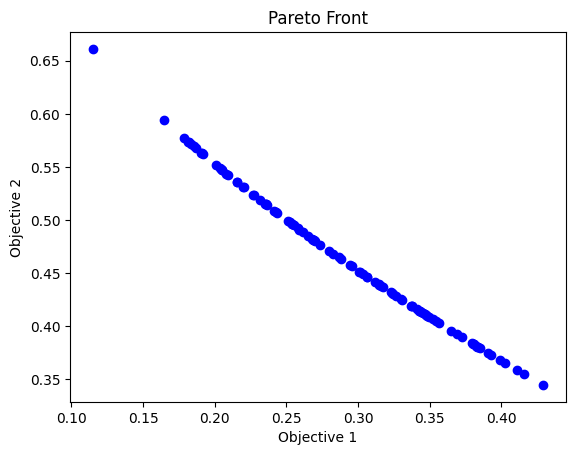

In [10]:
import matplotlib.pyplot as plt

# 最後の集団の目的関数値を取得
final_objective_values = np.array([objective_functions(ind) for ind in population])

# パレートフロントのプロット
plt.scatter(final_objective_values[:, 0], final_objective_values[:, 1], color='blue')
plt.title('Pareto Front')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.show()


NSGA-II（Non-dominated Sorting Genetic Algorithm II）は、**マルチオブジェクティブ最適化**を行うための進化的アルゴリズムの一種であり、複数の目的関数を同時に最適化する問題を解決するために使われます。このアルゴリズムの目的は、**パレート最適解**（どの解も他の解に完全には優れていない解）を見つけることです。

以下に、NSGA-IIがどのような流れで最適化を行っているかをまとめます：

### 1. **初期集団の生成**
   アルゴリズムは、まずランダムにいくつかの解（個体）を生成します。この集団が進化を通じて最適化され、より良い解を見つけていきます。

### 2. **目的関数の評価**
   各個体に対して、与えられた複数の目的関数を使ってそれぞれの目的関数値を計算します。たとえば、「コストの最小化」と「性能の最大化」などの異なる指標を用いて評価します。

### 3. **非優越ソート（Non-dominated Sorting）**
   各個体を比較し、他の個体に完全には支配されない（支配されていない）かどうかを判定します。ここで言う「支配」とは、ある個体がすべての目的関数で他の個体よりも優れていることを意味します。これに基づいて、パレート最適な解を見つけ、その個体をランク付けします。
   - **パレートフロント**：支配されていない個体は最初のフロント（ランク0）に位置し、それに支配される個体は次のフロント（ランク1）に位置します。

### 4. **クラウディング距離の計算**
   同じパレートフロントに属する個体間で、解の多様性を保つために、個体同士の距離を計算します。これを**クラウディング距離**と呼びます。クラウディング距離が大きい個体は、他の個体と異なる特徴を持っているため、選択時に優先されます。

### 5. **親の選択、交叉、突然変異**
   - **トーナメント選択**：クラウディング距離とランクに基づいて、次世代を生成するための親を選びます。優れたランクを持つ個体やクラウディング距離が大きい個体が優先的に選ばれます。
   - **交叉（Crossover）**：選ばれた親同士を組み合わせて新しい子供（次世代の個体）を生成します。交叉は、遺伝的アルゴリズムの一部で、異なる親の特徴を混ぜ合わせる手法です。
   - **突然変異（Mutation）**：突然変異は、解の多様性を維持するために、ランダムな変更を子供に適用します。

### 6. **次世代の生成と繰り返し**
   新しい世代の個体を作成し、再び目的関数を評価し、非優越ソートを行い、次の世代へと進化を繰り返します。このプロセスを設定された回数（世代数）まで繰り返し、最終的な解の集団を得ます。

### 7. **パレートフロントの出力**
   最終的に、複数の目的関数を同時に最適化した結果として、パレートフロント（最適解の集合）が得られます。これらの解は、どの解も他の解によって完全には支配されないため、様々なトレードオフを含んだ解として意味があります。

---

### NSGA-IIの特徴：
- **非優越ソート**：個体をパレートフロントに基づいてランク付けし、支配されていない解（パレート最適解）を効率的に探索します。
- **クラウディング距離**：同じフロント内での個体の多様性を保つための指標を計算し、進化が偏らないようにします。
- **進化的アルゴリズム**：遺伝的アルゴリズムのように、親の選択、交叉、突然変異を繰り返すことで最適解を探索します。

### アルゴリズムの最終目的：
NSGA-IIは、単一の最適解ではなく、**複数の競合する目的関数に対する最適なトレードオフの解**を探索することに重点を置いています。パレートフロントに沿った解の分布を見つけることで、複数の視点から最適解を選択できるという利点があります。

